Another useful part of the scikit-learn interface that we haven’t talked about yet is the ability of classifiers to 
provide uncertainty estimates of predictions. Often, you are not only interested in which class a classifier predicts
 for a certain test point, but also how certain it is that this is the right class. In practice, different kinds of 
 mistakes lead to very different outcomes in real-world applications. Imagine a medical application testing for 
 cancer. Making a false positive prediction might lead to a patient undergoing additional tests, while a false 
 negative prediction might lead to a serious disease not being treated. We will go into this topic in more detail in 
 future classes.

There are two different functions in scikit-learn that can be used to obtain uncertainty estimates from classifiers: decision_function and predict_proba. Most (but not all) classifiers have at least one of them, and many classifiers have both. Let’s look at what these two functions do on a synthetic two-dimensional dataset, when building a GradientBoostingClassifier classifier, which has both a decision_function and a predict_proba method:



In [3]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_circles
import numpy as np
from sklearn.model_selection import train_test_split

X, y = make_circles(noise=0.25, factor=0.5, random_state=1)

# we rename the classes "blue" and "red" for illustration purposes
y_named = np.array(["blue", "red"])[y]

# we can call train_test_split with arbitrarily many arrays;
# all will be split in a consistent manner
X_train, X_test, y_train_named, y_test_named, y_train, y_test = \
    train_test_split(X, y_named, y, random_state=0)

# build the gradient boosting model
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train_named)

GradientBoostingClassifier(random_state=0)

*1.0 The Decision Function*

In the binary classification case, the return value of decision_function is of shape (n_samples,), and it returns one floating-point number for each sample:

In [4]:
print("X_test.shape: {}".format(X_test.shape))
print("Decision function shape: {}".format(
      gbrt.decision_function(X_test).shape))

X_test.shape: (25, 2)
Decision function shape: (25,)


This value encodes how strongly the model believes a data point to belong to the “positive” class, in this case class 1. Positive values indicate a preference for the positive class, and negative values indicate a preference for the “negative” (other) class:



In [6]:
# show the first few entries of decision_function
print("Decision function:", gbrt.decision_function(X_test)[:6])

Decision function: [ 4.13592603 -1.70169917 -3.95106099 -3.62609552  4.28986642  3.66166081]


We can recover the prediction by looking only at the sign of the decision function:

In [7]:
print("Thresholded decision function:\n",
      gbrt.decision_function(X_test) > 0)
print("Predictions:\n", gbrt.predict(X_test))

Thresholded decision function:
 [ True False False False  True  True False  True  True  True False  True
  True False  True False False False  True  True  True  True  True False
 False]
Predictions:
 ['red' 'blue' 'blue' 'blue' 'red' 'red' 'blue' 'red' 'red' 'red' 'blue'
 'red' 'red' 'blue' 'red' 'blue' 'blue' 'blue' 'red' 'red' 'red' 'red'
 'red' 'blue' 'blue']


For binary classification, the “negative” class is always the first entry of the classes_ attribute, and the “positive” class is the second entry of classes_. So if you want to fully recover the output of predict, you need to make use of the classes_ attribute:

In [8]:
# make the boolean True/False into 0 and 1
greater_zero = (gbrt.decision_function(X_test) > 0).astype(int)
# use 0 and 1 as indices into classes_
pred = gbrt.classes_[greater_zero]
# pred is the same as the output of gbrt.predict
print("pred is equal to predictions:",
      np.all(pred == gbrt.predict(X_test)))

pred is equal to predictions: True


The range of decision_function can be arbitrary, and depends on the data and the model parameters:

In [9]:
decision_function = gbrt.decision_function(X_test)
print("Decision function minimum: {:.2f} maximum: {:.2f}".format(
      np.min(decision_function), np.max(decision_function)))

Decision function minimum: -7.69 maximum: 4.29


This arbitrary scaling makes the output of decision_function often hard to interpret.

In the following example we plot the decision_function for all points in the 2D plane using a color coding, next to a
 visualization of the decision boundary, as we saw earlier. We show training points as circles and test data as triangles (Figure 1):

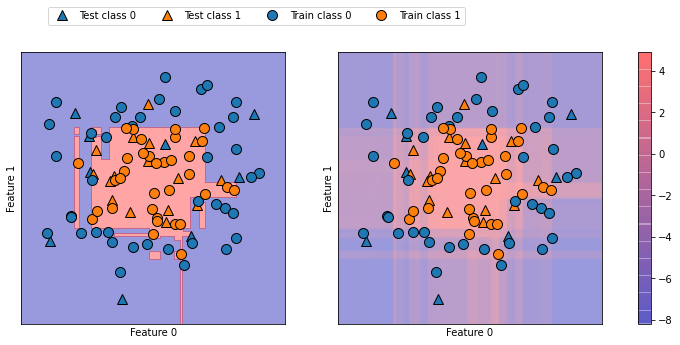

In [12]:
import matplotlib.pyplot as plt
import mglearn

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=.4,
                                fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(gbrt, X, ax=axes[1],
                                            alpha=.4, cm=mglearn.ReBl)

for ax in axes:
    # plot training and test points
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test,
                             markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train,
                             markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
cbar = plt.colorbar(scores_image, ax=axes.tolist())
axes[0].legend(["Test class 0", "Test class 1", "Train class 0",
                "Train class 1"], ncol=4, loc=(.1, 1.1))

Figure 1. Decision boundary (left) and decision function (right) for a gradient boosting model on a two-dimensional 
toy dataset. 


Encoding not only the predicted outcome but also how certain the classifier is provides additional information. However, in this visualization, it is hard to make out the boundary between the two classes.

*2.0 Predicting probabilities*

The output of predict_proba is a probability for each class, and is often more easily understood than the output of decision_function. It is always of shape (n_samples, 2) for binary classification:



In [13]:
print("Shape of probabilities:", gbrt.predict_proba(X_test).shape)


Shape of probabilities: (25, 2)


The first entry in each row is the estimated probability of the first class, and the second entry is the estimated probability of the second class. Because it is a probability, the output of predict_proba is always between 0 and 1, and the sum of the entries for both classes is always 1:

In [14]:
# show the first few entries of predict_proba
print("Predicted probabilities:")
print(gbrt.predict_proba(X_test[:6]))

Predicted probabilities:
[[0.01573626 0.98426374]
 [0.84575653 0.15424347]
 [0.98112869 0.01887131]
 [0.97407033 0.02592967]
 [0.01352142 0.98647858]
 [0.02504637 0.97495363]]


Because the probabilities for the two classes sum to 1, exactly one of the classes will be above 50% certainty. That class is the one that is predicted.

You can see in the previous output that the classifier is relatively certain for most points. How well the uncertainty actually reflects uncertainty in the data depends on the model and the parameters. A model that is more overfitted tends to make more certain predictions, even if they might be wrong. A model with less complexity usually has more uncertainty in its predictions. A model is called calibrated if the reported uncertainty actually matches how correct it is—in a calibrated model, a prediction made with 70% certainty would be correct 70% of the time.

In the following example (Figure 2) we again show the decision boundary on the dataset, next to the class probabilities for the class 1:

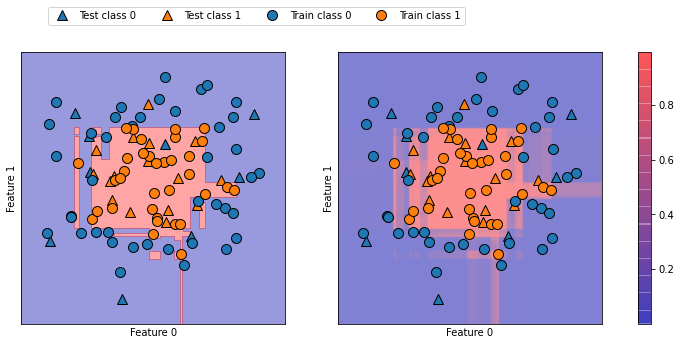

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

mglearn.tools.plot_2d_separator(
    gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(
    gbrt, X, ax=axes[1], alpha=.5, cm=mglearn.ReBl, function='predict_proba')

for ax in axes:
    # plot training and test points
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test,
                             markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train,
                             markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
cbar = plt.colorbar(scores_image, ax=axes.tolist())
axes[0].legend(["Test class 0", "Test class 1", "Train class 0",
                "Train class 1"], ncol=4, loc=(.1, 1.1))

Figure 2. Decision boundary (left) and predicted probabilities for the gradient boosting model shown in Figure 1

The boundaries in this plot are much more well-defined, and the small areas of uncertainty are clearly visible.

The scikit-learn website has a great comparison of many models and what their uncertainty estimates look like. We’ve 
reproduced this in Figure 3, and we encourage you to go through the example there.

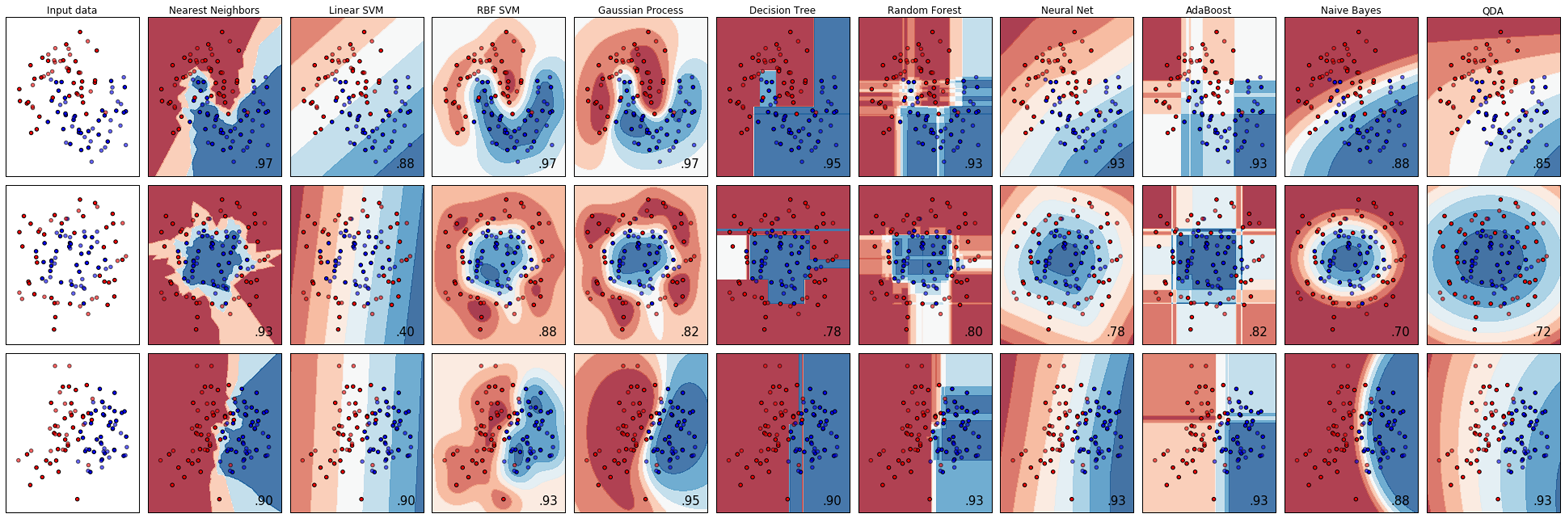

Figure 3. Comparison of several classifiers in scikit-learn on synthetic datasets (image courtesy http://scikit-learn
.org)